In [1]:
from MeetupHelperFunctions import *

import pandas as pd
import numpy as np

import pickle
import time
import gc
from collections import defaultdict

import scipy.sparse as sp
from scipy import linalg
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer, normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine, jaccard, euclidean, cdist
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from statistics import mode, StatisticsError

import tensorflow as tf
from tqdm import tqdm
from tffm import TFFMClassifier, TFFMRegressor

import matplotlib.pyplot as plt
%matplotlib inline

#data folder 
data_folder = 'data/'

# Read the raw group (item) data

In [2]:
with open (data_folder+'groups_select_info_v2.pkl', 'rb') as fp:
    select_groups_df = pickle.load(fp)
    
select_groups_df['group_id'] = select_groups_df['group_id'].astype('int')
select_groups_df['organizer_id'] = select_groups_df['organizer_id'].astype('int')
print('Number of groups: {}'.format(len(select_groups_df)))
print()
select_groups_df.columns

Number of groups: 18111



Index(['category.id', 'category.name', 'group_id', 'group_name',
       'organizer_id', 'join_mode', 'group_member_count', 'log_group_mem_cnt',
       'group_rating', 'visibility', 'group_location', 'group_age_months',
       'log_group_age_months', 'has_sponsors', 'group_topic_names',
       'group_topic_ids', 'group_topic_cnt', 'group_last_event_days',
       'yes_rsvp_count_mean', 'maybe_rsvp_count_mean', 'event_most_recent',
       'events_mean_freq', 'past_event_count', 'all_event_count',
       'group_event1_age_days', 'group_eventN_age_days'],
      dtype='object')

# Read the raw organizer (user) data

In [3]:
with open (data_folder+'organizers_select_info_v2.pkl', 'rb') as fp:
    select_organizers_df = pickle.load(fp)
select_organizers_df['organizer_id'] = select_organizers_df['organizer_id'].astype('int')
print('Number of organizers: {}'.format(len(select_organizers_df)))
print()
select_organizers_df.columns

Number of organizers: 13850



Index(['organizer_id', 'num_active_membership', 'log_num_active_membership',
       'messaging_pref', 'organizer_country', 'organizer_topic_names',
       'organizer_topic_ids', 'organizer_topic_cnt', 'membership_age_months',
       'log_membership_age_months', 'last_visit_days', 'log_last_visit_days',
       'organizer_grpN_age_days', 'log_grpN_age_days', 'num_groups'],
      dtype='object')

# Get the User/Item Interactions matrix

In [4]:
interactions_df = select_groups_df[['organizer_id', 'group_id', 
                                    'group_age_months', 'group_location']].copy()
# calculating the interaction strength
# assigning more weight to older groups using a simple exponential function 
# 15*12+6 = number of months since first meetup group
interactions_df['eventStrength'] = (interactions_df['group_age_months']
                                    .apply(lambda x: round(5*(1-np.exp(-1*x/(15*12+6))),4)))
interactions_df = interactions_df.merge(select_organizers_df[['organizer_id','num_groups']], 
                                        how = 'left', left_on = 'organizer_id', 
                                        right_on = 'organizer_id')
#Indexing by organizer_id to speed up the searches during evaluation
interactions_indexed_df = interactions_df.set_index('organizer_id')

print('# of unique user/item interactions: %d' % len(interactions_df))
interactions_df.head()

# of unique user/item interactions: 18111


,organizer_id,group_id,group_age_months,group_location,eventStrength,num_groups
0,294838,2657,186.0,Los Angeles-CA,3.1606,6
1,294838,153363,174.0,Los Angeles-CA,3.0380,6
2,1825635,153288,172.0,Chicago-IL,3.0168,1
3,7792265,178198,162.0,New York-NY,2.9073,1
4,5092271,329215,139.0,Chicago-IL,2.6318,1


In [5]:
def get_groups_organized(organizer_id, interactions_df):
    # Get the user's data and merge in the item information.
    interacted_items = interactions_df.loc[organizer_id]['group_id']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [6]:
def filter_not_organized_groups(organizer_id, group_ids):
    interacted_items = get_groups_organized(organizer_id, interactions_indexed_df)
    all_items = set(group_ids)
    non_interacted_items = all_items - interacted_items
    return set(non_interacted_items)

# Create group (item) feature matrix

In [7]:
def create_topic_feature(list_topic_ids, n_components=33, reduce_dim=True, verbose=True):
    topics_vocab_ = flatten(list_topic_ids)
    if verbose:
        print('Number of unique topics: {}'.format(len(topics_vocab_)))
        print(topics_vocab_[:5])

    #Concatenate the tokens to one string
    topic_ids_joined = [' '.join(x) for x in list_topic_ids]
        
    count_vectorizer = CountVectorizer(lowercase=False, vocabulary=topics_vocab_, 
                                       max_df=1.0, min_df=1, binary=True)
    #doc-topic matrix
    counts_vector   = count_vectorizer.fit_transform(topic_ids_joined)
    if verbose:
        print('Dimension of doc-topic matrix:', (counts_vector.shape))
    if reduce_dim:
        lsa = TruncatedSVD(n_components=n_components,n_iter=15,random_state=42)
        lsa.fit(counts_vector)
        if verbose:
            print("Sum of explained variances using {} components: {:.4f}".format(n_components, 
                                                                              lsa.explained_variance_ratio_.sum()))
            fig = plt.figure(figsize=(10,6));
            plt.title("Singular values for {} components of topics".format(n_components), size=15)
            plt.ylabel("Singular Values", size=15)
            plt.xlabel("Number of Components", size=15);
            plt.plot([x for x in range(len(lsa.singular_values_))], lsa.singular_values_);
            plt.ylim([10,150])

        topic_matred = lsa.transform(counts_vector)
        if verbose:
            print('Dimension of doc-topic matrix in reduced topic space:', topic_matred.shape)
        
        return topic_matred
    else:
        if verbose:
            print('Dimension of doc-topic matrix in original topic space:', counts_vector.shape)
        
        return counts_vector


In [8]:
# create dummy columns for categorical features
def create_category_as_dummy(df):
    category_cols = df.select_dtypes(include=['category']).columns

    df_dummy = df.select_dtypes(exclude=['category']).copy()
    lb = LabelBinarizer()

    for col in category_cols:
        if df[col].nunique() > 2:
            tmp = pd.DataFrame( lb.fit_transform(df[col]), 
                                columns=[col+'_'+str(c) for c in lb.classes_],
                                index = df.index )
            df_dummy = df_dummy.join (tmp)
        else:
            df_dummy[col] = (df[col] == df[col].unique()[0])

    return df_dummy

Number of unique topics: 20453
['1821', '827', '549872', '131992', '93297']
Dimension of doc-topic matrix: (18111, 20453)
Sum of explained variances using 100 components: 0.4017
Dimension of doc-topic matrix in reduced topic space: (18111, 100)
Columns with nulls: ['event_most_recent', 'events_mean_freq']
For Numerical features-> min:0.0000 | max:1.0000
Dimension of group features matrix: (18111, 149)


Index(['category.id_1', 'category.id_2', 'category.id_3', 'category.id_4',
       'category.id_5', 'category.id_6', 'category.id_8', 'category.id_9',
       'category.id_10', 'category.id_11',
       ...
       'topic90', 'topic91', 'topic92', 'topic93', 'topic94', 'topic95',
       'topic96', 'topic97', 'topic98', 'topic99'],
      dtype='object', length=149)

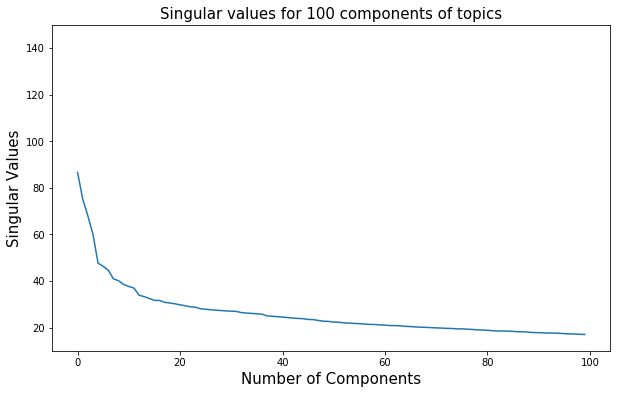

In [9]:
# create group (item) feature matrix
features_cat = ['category.id', 'group_location', 'join_mode']
features_num = ['group_member_count', 'group_rating', 'group_age_months',
                'yes_rsvp_count_mean', 'event_most_recent', 
                'events_mean_freq', 'past_event_count']
#features_num = ['log_group_mem_cnt', 'group_rating', 'log_group_age_months',
#                'yes_rsvp_count_mean', 'maybe_rsvp_count_mean',
#                'event_most_recent', 'events_mean_freq', 'past_event_count']
features_bin = ['has_sponsors',]
features_txt = 'group_topic_ids'

#topic vector
n_components=100
reduce_dim=True
topic_red_mat = create_topic_feature(list(select_groups_df[features_txt]),
                                     n_components=n_components,
                                     reduce_dim=reduce_dim)
if reduce_dim:
    scaler = MinMaxScaler()
    topic_red_mat = scaler.fit_transform(topic_red_mat)
    
group_text_df = pd.DataFrame(topic_red_mat)
group_text_df.columns = ['topic'+str(col) for col in group_text_df.columns]

#encode categorical variables as dummy
category_df = create_category_as_dummy(select_groups_df[features_cat])

#numerical features
numerical_df = select_groups_df[features_num].copy()

# handle the Null values
numerical_df['event_most_recent'].fillna(select_groups_df['group_last_event_days'], inplace=True)
null_check_df = check_nulls(numerical_df, numerical_df.columns, verbose = False)
null_cols = null_check_df.columns[~null_check_df.isin([0]).any()].tolist()
print('Columns with nulls:', null_cols)
null_fill_value = -1
numerical_df.fillna({'event_most_recent':null_fill_value,
                     'events_mean_freq' :null_fill_value}, inplace=True)
#scale the values
scaler = MinMaxScaler()
numerical_df = pd.DataFrame(scaler.fit_transform(numerical_df.copy()), 
                            columns=features_num)
print('For Numerical features-> min:{0:.4f} | max:{1:.4f}'.
      format(numerical_df.values.min(), numerical_df.values.max()))

binary_df = select_groups_df[features_bin].astype('uint')

#concatenate all the features
group_features_df = pd.concat([category_df, numerical_df, binary_df, group_text_df], axis=1)
group_features_df.index = select_groups_df['group_id']

del numerical_df, category_df, binary_df, null_check_df
gc.collect()

print('Dimension of group features matrix:', group_features_df.shape)
group_features_df.columns

In [10]:
group_features_df.head(3)

,category.id_1,category.id_2,category.id_3,category.id_4,category.id_5,category.id_6,category.id_8,category.id_9,category.id_10,category.id_11,...,topic90,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99
group_id,,,,,,,,,,,,,,,,,,,,,
2657,1,0,0,0,0,0,0,0,0,0,...,0.488454,0.452752,0.463651,0.431305,0.485262,0.497053,0.444029,0.406711,0.287683,0.500305
153363,1,0,0,0,0,0,0,0,0,0,...,0.471839,0.441864,0.452352,0.428949,0.471580,0.486888,0.466836,0.412603,0.295430,0.507463
153288,1,0,0,0,0,0,0,0,0,0,...,0.454868,0.406498,0.450871,0.438372,0.505683,0.508722,0.449255,0.409959,0.288783,0.527919


In [11]:
print('GROUP FEATURES --> MIN:{0:.4f} | MAX:{1:.4f} | MEAN:{2:.4f} | MEDIAN:{3:.4f}'
      .format(np.min(group_features_df.values), np.max(group_features_df.values), 
              np.mean(group_features_df.values), np.median(group_features_df.values)))

GROUP FEATURES --> MIN:0.0000 | MAX:1.0000 | MEAN:0.3053 | MEDIAN:0.3682


# Create organizer (user) feature matrix

In [ ]:
# create organizer (user) feature matrix
features_cat = ['organizer_country', 'messaging_pref']
features_num = ['log_num_active_membership', 'log_membership_age_months',
                'log_last_visit_days', 'log_grpN_age_days']
features_txt = 'organizer_topic_ids'

#topic vector
text_df = pd.DataFrame(create_topic_feature(list(select_organizers_df[features_txt]),n_components=12))
text_df.columns = ['topic'+str(col) for col in text_df.columns]

#encode categorical variables as dummy
category_df = create_category_as_dummy(select_organizers_df[features_cat])

#numerical features
numerical_df = select_organizers_df[features_num].copy()

# check for Null values
null_check_df = check_nulls(numerical_df, numerical_df.columns, verbose = False)
print('Columns with nulls:', 
      null_check_df.columns[~null_check_df.isin([0]).any()].tolist())

#scale the values
scaler = MinMaxScaler()
numerical_df = pd.DataFrame(scaler.fit_transform(numerical_df.copy()), 
                            columns=features_num)
print('For Numerical features-> min:{0:.4f} | max:{1:.4f}'.
      format(numerical_df.values.min(), numerical_df.values.max()))

#concatenate all the features
organizer_features_df = pd.concat([category_df, numerical_df, text_df], axis=1)
organizer_features_df.index = select_organizers_df['organizer_id']

del numerical_df, category_df, null_check_df
gc.collect()

print('Dimension of organizer features matrix:', organizer_features_df.shape)
organizer_features_df.columns

# Dimensionality reduction

Dimension of feature matrix in original feature space: (18111, 49)
Sum of explained variances using 30 components: 0.9603
Dimension of feature matrix in reduced feature space: (18111, 30)


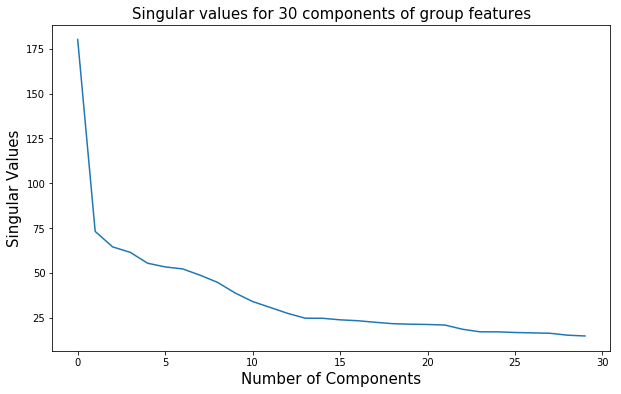

In [12]:
# applying SVD on group features other than topics
apply_svd_cols = group_features_df.columns.drop(list(group_features_df.filter(regex='topic')))
n_components = 30

print('Dimension of feature matrix in original feature space:', group_features_df[apply_svd_cols].values.shape)

lsa = TruncatedSVD(n_components=n_components,n_iter=15,random_state=42)
lsa.fit(group_features_df[apply_svd_cols].values)

print("Sum of explained variances using {} components: {:.4f}".format(n_components, 
                                                                      lsa.explained_variance_ratio_.sum()))
fig = plt.figure(figsize=(10,6));
plt.title("Singular values for {} components of group features".format(n_components), size=15)
plt.ylabel("Singular Values", size=15)
plt.xlabel("Number of Components", size=15);
plt.plot([x for x in range(len(lsa.singular_values_))], lsa.singular_values_);

feature_matred = lsa.transform(group_features_df[apply_svd_cols].values)
print('Dimension of feature matrix in reduced feature space:', feature_matred.shape)

In [15]:
# merge the feature and the topics
scaler = MinMaxScaler()
feature_matred = scaler.fit_transform(feature_matred)

#topic_cols = list(set(apply_svd_cols).symmetric_difference(group_features_df.columns))
feature_df = pd.DataFrame(feature_matred)
feature_df.columns = ['feature'+str(col) for col in feature_df.columns]
group_features_red_df = pd.concat([feature_df, group_text_df], axis=1)
group_features_red_df.index = select_groups_df['group_id']

del feature_df
gc.collect()

print('Dimension of reduced group features matrix:', group_features_red_df.shape)
group_features_red_df.columns

Dimension of reduced group features matrix: (18111, 130)


Index(['feature0', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5',
       'feature6', 'feature7', 'feature8', 'feature9',
       ...
       'topic90', 'topic91', 'topic92', 'topic93', 'topic94', 'topic95',
       'topic96', 'topic97', 'topic98', 'topic99'],
      dtype='object', length=130)

In [16]:
print('REDUCED GROUP FEATURES --> MIN:{0:.4f} | MAX:{1:.4f} | MEAN:{2:.4f} | MEDIAN:{3:.4f}'
      .format(np.min(group_features_red_df.values), np.max(group_features_red_df.values), 
              np.mean(group_features_red_df.values), np.median(group_features_red_df.values)))

REDUCED GROUP FEATURES --> MIN:0.0000 | MAX:1.0000 | MEAN:0.4105 | MEDIAN:0.4252


In [17]:
group_features_red_df.head(3)

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,topic90,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99
group_id,,,,,,,,,,,,,,,,,,,,,
2657,0.831402,0.231931,0.420383,0.752774,0.287470,0.410069,0.710448,0.541467,0.102293,0.179347,...,0.488454,0.452752,0.463651,0.431305,0.485262,0.497053,0.444029,0.406711,0.287683,0.500305
153363,0.832069,0.230510,0.420620,0.753902,0.288047,0.406840,0.709361,0.540879,0.106326,0.172803,...,0.471839,0.441864,0.452352,0.428949,0.471580,0.486888,0.466836,0.412603,0.295430,0.507463
153288,0.788183,0.258367,0.494248,0.669543,0.379367,0.610550,0.131082,0.280319,0.108317,0.257900,...,0.454868,0.406498,0.450871,0.438372,0.505683,0.508722,0.449255,0.409959,0.288783,0.527919


# Method 1: Content based similarity

## Create user profile for each organizer

In [18]:
def get_item_profile(item_id, reduced_dim):
    if reduced_dim:
        item_profile = group_features_red_df.loc[item_id]
    else:    
        item_profile = group_features_df.loc[item_id]
    return item_profile

def get_item_profiles(ids, reduced_dim):
    if type(ids) == pd.Series:
        item_profiles_list = [get_item_profile(x, reduced_dim) for x in ids]
        item_profiles = np.vstack(item_profiles_list)
    else:
        item_profiles = get_item_profile(ids, reduced_dim).values.reshape(1, -1)
    return item_profiles

def build_users_profile(organizer_id, weighted, reduced_dim):
    interactions_person_df = interactions_indexed_df.loc[organizer_id]
    user_item_profiles = get_item_profiles(interactions_person_df['group_id'], reduced_dim)
    if weighted:
        user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
        #average of item profiles by the interactions strength
        user_item_strengths_weighted_avg = np.mean(np.multiply(user_item_profiles, user_item_strengths), axis=0)
        user_profile_norm = normalize(user_item_strengths_weighted_avg.reshape(1, -1))
    
        return user_profile_norm
    else:
        return user_item_profiles

def build_users_profiles(weighted=True, reduced_dim=False): 
    user_profiles = {}
    for organizer_id in interactions_indexed_df.index.unique():
        user_profiles[organizer_id] = build_users_profile(organizer_id, 
                                                          weighted,
                                                          reduced_dim)
    return user_profiles

In [19]:
print('Building user profiles using original features..')
user_profiles = build_users_profiles(weighted=False, reduced_dim=False)
print('User profiles created for {} organizers using original features'
      .format(len(user_profiles)))

Building user profiles using original features..
User profiles created for 13850 organizers using original features


In [20]:
print('Building user profiles using reduced dimensional features..')
user_profiles_red = build_users_profiles(weighted=False, reduced_dim=True)
print('User profiles created for {} organizers using reduced dimensional features'
      .format(len(user_profiles_red)))

Building user profiles using reduced dimensional features..
User profiles created for 13850 organizers using reduced dimensional features


In [22]:
(user_profiles[294838]).shape

(6, 149)

## Find similar items and recommend

In [23]:
def get_similar_items_to_user_profile(person_id, topn=100, reduced_dim=False):
    #Computes the distance between the user profile and all item profiles
    if reduced_dim:
        similarities = cdist(user_profiles_red[person_id], 
                             group_features_red_df.values, 
                             metric='euclidean')
    else:
        similarities = cdist(user_profiles[person_id], 
                             group_features_df.values, 
                             metric='euclidean')
        
    #Gets the top similar items
    similar_indices = similarities.argsort(axis=1)[:,:topn]
    
    #Sort the similar items by similarity
    if reduced_dim:
        similar_items = sorted([(group_features_red_df.index[i], similarities[num,i]) 
                                for num,row in enumerate(similar_indices) for i in row], 
                               key=lambda x: x[1])
    else:
        similar_items = sorted([(group_features_df.index[i], similarities[num,i]) 
                                for num,row in enumerate(similar_indices) for i in row], 
                               key=lambda x: x[1])
        
    return similar_items[:topn]

In [24]:
def recommend_items(user_id, items_to_ignore=[], topn=10, reduced_dim=False, verbose=True):
    similar_items = get_similar_items_to_user_profile(user_id, topn=topn, reduced_dim=reduced_dim)
    #Ignores items the user has already interacted
    similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
    recommendations_df = pd.DataFrame(similar_items_filtered, 
                                      columns=['group_id', 'recStrength']).head(topn)
    if verbose:
        recommendations_df = (recommendations_df.merge(select_groups_df, how = 'left', 
                                                       left_on = 'group_id', 
                                                       right_on = 'group_id')
                              [['recStrength', 'group_id', 'group_name', 'category.name', 'group_rating',
                                'group_location', 'group_member_count', 'group_age_months',
                                'has_sponsors', 'event_most_recent', 'events_mean_freq'
                                ]])

    return recommendations_df

In [25]:
# test case
organizer_id =  1825635 #216248567 # 
groups_to_ignore = get_groups_organized(organizer_id, interactions_indexed_df)
recommend_items(organizer_id, groups_to_ignore, topn=10, reduced_dim=False, verbose=True)

,recStrength,group_id,group_name,category.name,group_rating,group_location,group_member_count,group_age_months,has_sponsors,event_most_recent,events_mean_freq
0,0.814864,1752853,Chicago Improv Practice Group,fine arts/culture,4.86,Chicago-IL,770,88.0,True,278.0,29.0
1,1.064154,978913,The Chicago Museum Meetup Group,fine arts/culture,4.46,Chicago-IL,2024,123.0,True,648.0,26.0
2,1.160543,639910,Chicago Acting Meetup Group,fine arts/culture,4.48,Chicago-IL,821,128.0,True,0.0,13.0
3,1.434442,19203922,Chicago Theater Meetup,fine arts/culture,4.35,Chicago-IL,763,28.0,False,6.0,1.0
4,1.464826,8588222,Chicago Culture and Arts Club,fine arts/culture,4.66,Chicago-IL,2113,59.0,True,20.0,6.0
5,1.500971,26246864,Next Gen Art Collecting,fine arts/culture,5.00,Chicago-IL,37,6.0,True,122.0,17.0
6,1.519872,23498932,Chicago: The Business & The Craft of Acting,fine arts/culture,4.00,Chicago-IL,280,12.0,False,69.0,5.0
7,1.541484,2390501,Chicago Design Workshops,fine arts/culture,4.75,Chicago-IL,186,80.0,False,10.0,216.0
8,1.548112,16621602,Stand & Deliver Performing Arts - Improv Meetu...,fine arts/culture,3.80,Chicago-IL,817,44.0,False,64.0,9.0


In [26]:
# test case
organizer_id =  1825635 #216248567 # 
groups_to_ignore = get_groups_organized(organizer_id, interactions_indexed_df)
recommend_items(organizer_id, groups_to_ignore, topn=10, reduced_dim=True, verbose=True)

,recStrength,group_id,group_name,category.name,group_rating,group_location,group_member_count,group_age_months,has_sponsors,event_most_recent,events_mean_freq
0,0.728889,1752853,Chicago Improv Practice Group,fine arts/culture,4.86,Chicago-IL,770,88.0,True,278.0,29.0
1,0.930806,19203922,Chicago Theater Meetup,fine arts/culture,4.35,Chicago-IL,763,28.0,False,6.0,1.0
2,0.944942,153363,Hollywood- LA Theatre Meetup Sponsored by Perf...,fine arts/culture,4.93,Los Angeles-CA,323,174.0,True,355.0,21.0
3,1.011340,23498932,Chicago: The Business & The Craft of Acting,fine arts/culture,4.00,Chicago-IL,280,12.0,False,69.0,5.0
4,1.030890,978913,The Chicago Museum Meetup Group,fine arts/culture,4.46,Chicago-IL,2024,123.0,True,648.0,26.0
5,1.034316,25347056,CTM II,fine arts/culture,0.00,Chicago-IL,48,8.0,False,16.0,10.0
6,1.034373,25746275,PLAYcationers,fine arts/culture,0.00,Chicago-IL,48,7.0,False,204.0,NaN
7,1.054661,7981052,Improv Classes & Workshops,fine arts/culture,4.56,San Francisco-CA,277,60.0,False,197.0,11.0
8,1.063196,7761862,Adventure Design Group / Bay Area,fine arts/culture,4.83,San Francisco-CA,1734,61.0,True,141.0,45.0


In [27]:
grp_ids = interactions_indexed_df.loc[organizer_id]['group_id']
if type(grp_ids) != pd.Series:
    grp_ids = [grp_ids]
(select_groups_df[select_groups_df['group_id'].isin(grp_ids)]
 [['category.name','group_name', 'group_location', 'group_member_count', 'group_age_months',
   'group_rating', 'has_sponsors', 'event_most_recent', 'events_mean_freq']])    

,category.name,group_name,group_location,group_member_count,group_age_months,group_rating,has_sponsors,event_most_recent,events_mean_freq
2,fine arts/culture,Chicago Theater Goers Meetup Group,Chicago-IL,601,172.0,4.32,True,1.0,7.0


# Method 2: Clustering

## A. Using original features

In [ ]:
def clusterGroups(X, verbose=True):
    i = 1
    sse_list = []
    while True:
        #build two kmeans models starting with 2 and 3 clusters and repeat until dss<0.2
        i+=1
        
        cluster1 = KMeans(n_clusters=i, random_state=42, n_jobs=-1).fit(X)
        cluster2 = KMeans(n_clusters=i+1, random_state=42, n_jobs=-1).fit(X)

        sse_list.append(cluster1.inertia_) 
        
        #decision criterion
        dss = ((cluster1.inertia_ - cluster2.inertia_)/cluster1.inertia_)
        if verbose:
            print('change in SSE for k={0}: {1:.4f}'.format(i, dss))
            
        #exit if dss < 0.2
        if (dss<0.01)&(i>=40):
            break
            
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(2,i+1),sse_list)
    plt.title("SSE for K-Means clustering", size=15)
    plt.ylabel("SSE", size=15)
    plt.xlabel("Number of clusters", size=15);

    return dss, i

dss, i = clusterGroups(group_features_df.values, verbose=False)

## Find K clusters and label the groups

In [ ]:
num_clusters = 30
group_labels = KMeans(n_clusters=num_clusters, random_state=42, n_jobs=-1).fit_predict(group_features_df.values)
group_label_df = pd.DataFrame(group_labels, 
                              columns=['group_label'],
                              index = group_features_df.index)
group_label_df.head()

In [ ]:
interactions_labeled_df = interactions_indexed_df.merge(group_label_df.reset_index(), how='left',
                                                        left_on='group_id', right_on='group_id'
                                                        )
interactions_labeled_df.index = interactions_indexed_df.index
#interactions_labeled_df.reset_index(inplace=True)
interactions_labeled_df.head()

In [ ]:
def get_users_cluster(organizer_id, interactions_labeled_df):
    interactions_person_df = interactions_labeled_df.loc[organizer_id]
    #organizers with only one group
    if type(interactions_person_df) == pd.Series:
        return interactions_person_df['group_label']
    #organizers with multiple groups
    interactions_person_df.reset_index(inplace=True)
    try:
        #get the most frequent cluster label
        user_cluster = mode(interactions_person_df['group_label'])
    except StatisticsError:
        #else get the cluster label of the newest group
        user_cluster = interactions_person_df.loc[interactions_person_df['group_age_months'].idxmin()]['group_label']
    return user_cluster

def get_users_clusters(): 
    user_clusters = {}
    for organizer_id in interactions_labeled_df.index.unique():
        user_clusters[organizer_id] = get_users_cluster(organizer_id, interactions_labeled_df)
    return user_clusters

In [ ]:
print('Getting user cluster labels..')
users_labels = get_users_clusters()
print('User labels created for {} organizers'.format(len(users_labels)))

In [ ]:
def get_similar_items_to_user_profile(person_id):
    #get all groups in the user's cluster
    numCluster = users_labels[person_id]
    cluster_group_ids = ((interactions_labeled_df[(interactions_labeled_df['group_label']==numCluster) &
                                                  (interactions_labeled_df.index!=person_id)])
                         .reset_index())['group_id']
    cluster_group_features_df = group_features_df[group_features_df.index.isin(cluster_group_ids)]
    #Computes the distance between the user profile (from Method 1) and all item profiles in cluster
    similarities = cdist(user_profiles[person_id], cluster_group_features_df.values, metric='euclidean')
    #Gets the top similar items
    similar_indices = similarities.argsort().flatten()
    #Sort the similar items by similarity
    similar_items = sorted([(cluster_group_features_df.index[i], similarities[0,i]) 
                            for i in similar_indices], 
                           key=lambda x: x[1])
    return similar_items

In [ ]:
def recommend_items(user_id, items_to_ignore=[], topn=10, verbose=False):
    similar_items = get_similar_items_to_user_profile(user_id)
    #Ignores items the user has already interacted
    similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
    recommendations_df = pd.DataFrame(similar_items_filtered, 
                                      columns=['group_id', 'recStrength']).head(topn)

    if verbose:
        recommendations_df = (recommendations_df.merge(select_groups_df, how = 'left', 
                                                       left_on = 'group_id', 
                                                       right_on = 'group_id')
                              [['recStrength', 'group_id', 'group_name', 'category.name', 'group_rating',
                                'group_location', 'group_member_count', 'group_age_months',
                                'has_sponsors', 'event_most_recent', 'events_mean_freq'
                                ]])

    return recommendations_df

In [ ]:
organizer_id = 216248567
groups_to_ignore = get_groups_organized(organizer_id, interactions_indexed_df)
recommend_items(organizer_id, groups_to_ignore, verbose=True)

In [ ]:
grp_ids = interactions_indexed_df.loc[organizer_id]['group_id']
(select_groups_df[select_groups_df['group_id'].isin(grp_ids)]
 [['category.name','group_name', 'group_location', 'group_member_count', 'group_age_months',
   'group_rating', 'has_sponsors', 'event_most_recent', 'events_mean_freq']])

# Method 3: Factorization Machines

## target variable

In [ ]:
target = 'past_event_count'
q95 = np.percentile(select_groups_df[target], 95)

fig = plt.figure(figsize=(10,6));
plt.title("Histogram of target", size=15)
plt.ylabel("Count", size=15)
plt.xlabel(target, size=15);
plt.hist(select_groups_df[select_groups_df[target]<=q95][target], bins=50);
#select_groups_df.hist(column=target, bins=20);

In [ ]:
log_target = np.array([np.log10(t) if t>0 else 0 for t in select_groups_df[target]])
fig = plt.figure(figsize=(10,6));
plt.title("Histogram of log(target)", size=15)
plt.ylabel("Count", size=15)
plt.xlabel(target, size=15);
plt.hist(log_target, bins=15);

In [ ]:
print('LOG(Target) --> MIN:{0:.4f} | MAX:{1:.4f} | MEAN:{2:.4f} | MEDIAN:{3:.4f}'
      .format(np.min(log_target), np.max(log_target), np.mean(log_target), np.median(log_target)))

## Feature A. Merge the group and organizer features

In [ ]:
organizer_features_df_copy = organizer_features_df.copy()
organizer_features_df_copy.reset_index(inplace=True)

group_features_df_copy = group_features_df.copy()
group_features_df_copy.reset_index(inplace=True)
#using the original values for the target, not the normalized ones
group_features_df_copy.drop([target], axis=1, inplace=True)
group_features_df_copy = group_features_df_copy.merge(select_groups_df[['organizer_id', 'group_id', target]],
                                                      left_on='group_id', right_on='group_id')

organizer_group_features_combined_df = (organizer_features_df_copy.merge(group_features_df_copy, how='inner',
                                                                 left_on='organizer_id', right_on='organizer_id'))
print('Dimension of the merged feature matrix:', organizer_group_features_combined_df.shape)
print(organizer_group_features_combined_df.columns)

## Feature B. Use only group features

In [ ]:
group_features_df_copy = group_features_df.copy()
group_features_df_copy.reset_index(inplace=True)
#using the original values for the target, not the normalized ones
group_features_df_copy.drop([target], axis=1, inplace=True)
group_features_df_copy = group_features_df_copy.merge(select_groups_df[['group_id', 'organizer_id', target]],
                                                      left_on='group_id', right_on='group_id')

organizer_group_features_combined_df = group_features_df_copy.copy()

print('Dimension of the merged feature matrix:', organizer_group_features_combined_df.shape)
print(organizer_group_features_combined_df.columns)

## Cross Validation/ Holdout Split

In [ ]:
FMfeatures_df, FMtarget_df = (organizer_group_features_combined_df.drop([target,'group_id','organizer_id'],axis=1), 
                              organizer_group_features_combined_df[target])
print('Features Dataset shape: {}'.format(FMfeatures_df.shape))

feature_cv_idx, feature_holdout_idx, target_cv, target_holdout = train_test_split(FMfeatures_df.index, 
                                                                                  FMtarget_df, 
                                                                                  random_state=42, 
                                                                                  test_size=0.2)
print('Cross-Validation Features Dataset shape: {}'.format(FMfeatures_df.iloc[feature_cv_idx].shape))
print('Holdout Features Dataset shape: {}'.format(FMfeatures_df.iloc[feature_holdout_idx].shape))

## Cross Validation

In [ ]:
feature_train_idx, feature_test_idx, target_train, target_test = train_test_split(feature_cv_idx, 
                                                                                  target_cv, 
                                                                                  random_state=42, 
                                                                                  test_size=0.2)
print('Train set Features Dataset shape: {}'.format(FMfeatures_df.iloc[feature_train_idx].shape))
print('Test set Features Dataset shape : {}'.format(FMfeatures_df.iloc[feature_test_idx].shape))

## one-hot-encoded organizer ids and one-hot-encoded group ids¶

In [ ]:
organizer_group_features_combined_df.columns

In [ ]:
feature_ids = ['organizer_id', 'group_id']

encoder_lb = defaultdict()
for feature in feature_ids:
    enc = LabelBinarizer(sparse_output=True)
    enc = enc.fit(organizer_group_features_combined_df[feature].values)
    # create a dictionary of encoders
    encoder_lb[feature] = enc
    
X_tr_list = []
X_te_list = []
for feature in feature_ids:
    enc = encoder_lb[feature]
    X_tr_list.append(enc.transform(organizer_group_features_combined_df.iloc[feature_train_idx][feature].values))
    X_te_list.append(enc.transform(organizer_group_features_combined_df.iloc[feature_test_idx][feature].values))
    
X_tr_sparse = sp.hstack(X_tr_list)
X_te_sparse = sp.hstack(X_te_list)

X_tr_sparse = sp.csr_matrix(X_tr_sparse)
X_te_sparse = sp.csr_matrix(X_te_sparse)

del X_tr_list[:]
del X_te_list[:]
gc.collect()

print('Non-zeros rate in feature set: {:.05f}'.format(np.mean(X_tr_sparse != 0)))
print('Dimension of one hot encoded train set feature vector:{}'.format(X_tr_sparse.shape))
print('Dimension of one hot encoded test set feature vector:{}'.format(X_te_sparse.shape))

## training Model using both group and organizer features

In [ ]:
X_tr_dense = FMfeatures_df.iloc[feature_train_idx].values
X_te_dense = FMfeatures_df.iloc[feature_test_idx].values
#y_tr = target_train.values
#y_te = target_test.values
#using log as target
y_tr = np.array([np.log10(t) if t>0 else 0 for t in target_train.values])
y_te = np.array([np.log10(t) if t>0 else 0 for t in target_test.values])

classifier_threshold = np.mean(y_tr)

print('Dimension of X_tr_dense:',X_tr_dense.shape)
print('Predicting {}'.format(target))
model = TFFMRegressor(
    order=4, 
    rank=5, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
    n_epochs=40, 
    batch_size=256,
    init_std=0.01,
    reg=0.001, # 0 for no L2 regularization
#    reweight_reg=True,
    input_type='dense',
    seed=42
)
model.fit(X_tr_dense, y_tr, show_progress=True)

predictions_tr = model.predict(X_tr_dense)
predictions_te = model.predict(X_te_dense)

print('Accuracy on train set: {}'.format(accuracy_score(y_tr>classifier_threshold, 
                                                        predictions_tr>classifier_threshold)))
print('Accuracy on validation set: {}'.format(accuracy_score(y_te>classifier_threshold, 
                                                       predictions_te>classifier_threshold)))
print('RMSE on training set: {}'.format(np.sqrt(mean_squared_error(y_tr, predictions_tr))))
print('RMSE on validation set: {}'.format(np.sqrt(mean_squared_error(y_te, predictions_te))))
print('RMSE/Mean on validation set: {}'.format(np.sqrt(mean_squared_error(y_te, 
                                                                          predictions_te))/np.mean(y_te)))

model.destroy()

## training Model using both group features and IDs

In [ ]:
X_tr_dense = FMfeatures_df.iloc[feature_train_idx].values
X_te_dense = FMfeatures_df.iloc[feature_test_idx].values

X_tr_all_sparse = sp.csr_matrix(sp.hstack((X_tr_sparse, sp.csr_matrix(X_tr_dense))))
X_te_all_sparse = sp.csr_matrix(sp.hstack((X_te_sparse, sp.csr_matrix(X_te_dense))))

#y_tr = target_train.values
#y_te = target_test.values
#using log as target
y_tr = np.array([np.log10(t) if t>0 else 0 for t in target_train.values])
y_te = np.array([np.log10(t) if t>0 else 0 for t in target_test.values])

classifier_threshold = np.mean(y_tr)

print('Dimension of X_tr_all_sparse:',X_tr_all_sparse.shape)
print('Predicting {}'.format(target))
model = TFFMRegressor(
    order=2, 
    rank=5, 
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01),#AdamOptimizer(learning_rate=0.001), 
    n_epochs=300, 
    batch_size=200,
    init_std=0.1,
    reg=1, # 0 for no L2 regularization
#    reweight_reg=True,
    input_type='sparse',
    seed=42
)
model.fit(X_tr_all_sparse, y_tr, show_progress=True)

predictions_tr = model.predict(X_tr_all_sparse)
predictions_te = model.predict(X_te_all_sparse)

print('Accuracy on train set: {}'.format(accuracy_score(y_tr>classifier_threshold, 
                                                        predictions_tr>classifier_threshold)))
print('Accuracy on validation set: {}'.format(accuracy_score(y_te>classifier_threshold, 
                                                       predictions_te>classifier_threshold)))
print('RMSE on training set: {}'.format(np.sqrt(mean_squared_error(y_tr, predictions_tr))))
print('RMSE on validation set: {}'.format(np.sqrt(mean_squared_error(y_te, predictions_te))))
print('RMSE/Mean on validation set: {}'.format(np.sqrt(mean_squared_error(y_te, 
                                                                          predictions_te))/np.mean(y_te)))

#model.destroy()

## testing model

In [ ]:
X_ho_dense = FMfeatures_df.iloc[feature_holdout_idx].values
y_ho = np.array([np.log10(t) if t>0 else 0 for t in target_holdout.values])
predictions_ho = model.predict(X_ho_dense)

print('RMSE on holdout set: {}'.format(np.sqrt(mean_squared_error(y_ho, predictions_ho))))
print('RMSE/Mean on holdout set: {}'.format(np.sqrt(mean_squared_error(y_ho, 
                                                                          predictions_ho))/np.mean(y_ho)))
model.destroy()

## Recommendations based on predicted target

In [ ]:
def create_sparse_matrix(organizer_id, groups_to_ignore):
    rows_to_encode = ~organizer_group_features_combined_df['group_id'].isin(groups_to_ignore)
    X_dense = FMfeatures_df[rows_to_encode].values
    
    X_list = []
    enc = encoder_lb['organizer_id']
    X_list.append(sp.vstack([enc.transform([organizer_id])]*sum(rows_to_encode)))
    enc = encoder_lb['group_id']
    group_ids2enc = organizer_group_features_combined_df[rows_to_encode]['group_id']
    X_list.append(enc.transform(group_ids2enc))
    X_sparse = sp.hstack(X_list)
    del X_list[:]
    X_all_sparse = sp.csr_matrix(sp.hstack((X_sparse, sp.csr_matrix(X_dense))))
    del X_sparse, X_dense
        
    return group_ids2enc, X_all_sparse

In [ ]:
def get_similar_items_to_user_profile(person_id, topn=10):
    #Computes the target between the user profile and all item profiles in cluster
    group_ids_ignore = get_groups_organized(person_id, interactions_indexed_df)
    group_ids_compared, user_all_groups_sparse_mat = create_sparse_matrix(person_id, group_ids_ignore)

    similarities = model.predict(user_all_groups_sparse_mat)
    del user_all_groups_sparse_mat

    #Gets the top similar items
    similar_indices = similarities.argsort().flatten()[-topn:]
    #Sort the similar items by similarity
    similar_items = sorted([(group_ids_compared[i], similarities[i]) 
                            for i in similar_indices], 
                           key=lambda x: -x[1])
    return similar_items

In [ ]:
def recommend_items(user_id, items_to_ignore=[], topn=10, verbose=False):
    similar_items = get_similar_items_to_user_profile(user_id)
    #Ignores items the user has already interacted
    similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
    recommendations_df = pd.DataFrame(similar_items_filtered, 
                                      columns=['group_id', 'recStrength']).head(topn)

    if verbose:
        recommendations_df = (recommendations_df.merge(select_groups_df, how = 'left', 
                                                       left_on = 'group_id', 
                                                       right_on = 'group_id')
                              [['recStrength', 'group_id', 'group_name', 'category.name', 'group_rating',
                                'group_location', 'group_member_count', 'group_age_months',
                                'has_sponsors', 'event_most_recent', 'events_mean_freq'
                                ]])

    return recommendations_df

In [ ]:
organizer_id = 216248567
recommend_items(organizer_id, items_to_ignore=[], verbose=True)

In [ ]:
grp_ids = get_groups_organized(organizer_id, interactions_indexed_df)
(select_groups_df[select_groups_df['group_id'].isin(grp_ids)]
 [['category.name','group_name', 'group_location', 'group_member_count', 'group_age_months',
   'group_rating', 'has_sponsors', 'event_most_recent', 'events_mean_freq']])